In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading Necessary libraries

In [4]:
import nltk
from nltk.corpus import stopwords # 불용어(의미 없는 단어 토큰 제거. ex, 조사, 접미사)
from nltk.stem.porter import PorterStemmer #어간(stem)추출: 단어를 원형으로 표기 (knowing -> know)
from wordcloud import WordCloud, STOPWORDS 
from nltk.stem import WordNetLemmatizer #접사(affix)추출: 단어에 추가적인 의미를 주는 부분 (likes -> like)
from nltk.tokenize import word_tokenize, sent_tokenize # 말뭉치(corpus)를 토큰으로 나누는 것 (단어 토큰화, 문장 토큰화)
from bs4 import BeautifulSoup
import re, string, unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation # , !, ?, . 와 같은 구두점 제거
import keras
from keras.models import Sequential
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd

### Reading the dataset

In [5]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Euron/Covid-NLP/Corona_NLP_train.csv', encoding='latin_1')
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Euron/Covid-NLP/Corona_NLP_test.csv",encoding='latin_1')

In [6]:
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


### Check for any null values

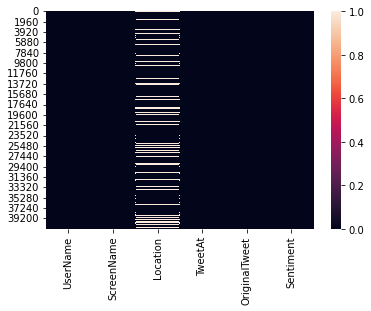

In [8]:
# check for null value in train_data
sns.heatmap(train_data.isnull())

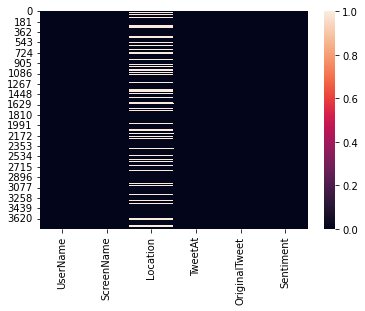

In [9]:
# check for null value in test_data
sns.heatmap(test_data.isnull())

### drop duplicate and 'NA' values

In [10]:
train_data.drop_duplicates(inplace = True)
test_data.drop_duplicates(inplace = True)

In [11]:
train_data.dropna(inplace = True)
test_data.dropna(inplace = True)

### Making checkpoint

In [12]:
train_df = train_data.copy()
test_df = test_data.copy()

In [13]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive


### Check if any null value exists

In [14]:
print(train_df.isnull().sum())
print('*'*50)
print(test_df.isnull().sum())

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64
**************************************************
UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


In [15]:
train_data.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

### performin small EDA

In [16]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(11,4)})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


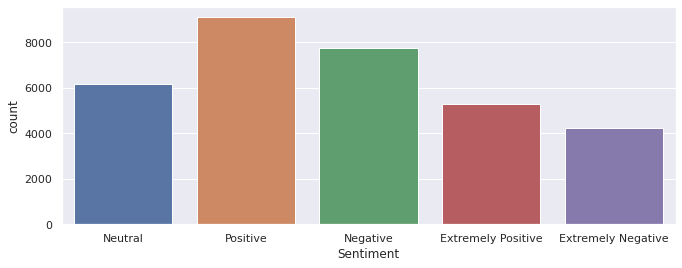

In [17]:
sns.countplot(train_df['Sentiment'])

In [18]:
train_df.shape, test_df.shape

((32567, 6), (2964, 6))

**5개의 감정을 3개의 감정으로 축소**

(강한 긍정 -> 긍정, 강한 부정 -> 부정, 중립)

In [19]:
def change_sen(sentiment):
    if sentiment == 'Extremely Positive':
        return 'positive'
    elif sentiment == 'Extremely Negative':
        return 'negative'
    elif sentiment == 'Positive':
        return 'positive'
    elif sentiment == 'Negative':
        return 'negative'
    else:
        return 'netural'

Applying the change_sen function/method

In [20]:
train_df['Sentiment'] = train_df['Sentiment'].apply(lambda x: change_sen(x))
test_df['Sentiment'] = test_df['Sentiment'].apply(lambda x: change_sen(x))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


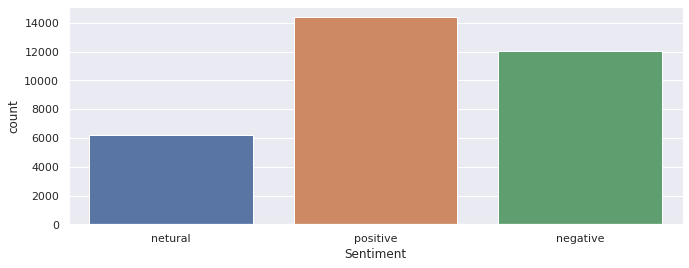

In [21]:
sns.countplot(train_df['Sentiment'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


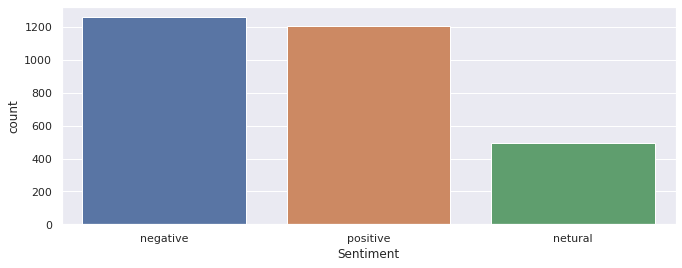

In [22]:
sns.countplot(test_df['Sentiment'])

Nowo time for Data Clearning and processing

In [23]:
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
# load stop words
stop_word = stopwords.words("english")

In [25]:
# 정규 표현식
# re.sub('찾을 패턴', '찾은 패턴을 변경할 내용', '원본')

def clean(text):
    # remove urls
    text = re.sub(r'http\S+', " ", text)
    
    # remove mentions
    text = re.sub(r'@\w+', ' ', text)
    
    # remove hastags
    text = re.sub(r'#\w+', ' ', text)
    
    # remove digits
    text = re.sub(r'\d+', ' ', text)
    
    # remove html tags
    text = re.sub('r<.*?>', ' ', text)
    
    # remove stop words
    text = text.split()
    text = " ".join([word for word in text if not word in stop_word])
    
    return text

In [26]:
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: clean(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: clean(x))

In [27]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,,netural
1,3800,48752,UK,16-03-2020,advice Talk neighbours family exchange phone n...,positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths give elderly...,positive
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news regionÂs first confirmed COVID- case ...,positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier grocery store sharing insights To prov...,positive


Original Tweet, Sentiment 만 필요함!

In [28]:
df_train = train_df.iloc[:, 4:]
df_test = test_df.iloc[:, 4:]

In [29]:
df_train.head()

,OriginalTweet,Sentiment
0,,netural
1,advice Talk neighbours family exchange phone n...,positive
2,Coronavirus Australia: Woolworths give elderly...,positive
5,As news regionÂs first confirmed COVID- case ...,positive
6,Cashier grocery store sharing insights To prov...,positive


now mapping the sentiment
* 0: Netural
* 1: Positive
* 2: Negative

In [30]:
l = {"netural":0, "positive":1, "negative":2}

In [31]:
# 오 dictionary로 map은 첨 해보는 듯..??
df_train['Sentiment'] = df_train["Sentiment"].map(l)
df_test['Sentiment'] = df_test['Sentiment'].map(l)

In [32]:
df_train.head()

,OriginalTweet,Sentiment
0,,0
1,advice Talk neighbours family exchange phone n...,1
2,Coronavirus Australia: Woolworths give elderly...,1
5,As news regionÂs first confirmed COVID- case ...,1
6,Cashier grocery store sharing insights To prov...,1


In [33]:
x_train = df_train['OriginalTweet'].copy()
x_test = df_test['OriginalTweet'].copy()

y_train = df_train['Sentiment'].copy()
y_test = df_test['Sentiment'].copy()

In [34]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((32567,), (32567,), (2964,), (2964,))

Maximum length of sequence

In [35]:
max_len = np.max(x_train.apply(lambda x: len(x)))
max_len

286

Tokenizer initialization

In [36]:
tokenizer = Tokenizer()

In [37]:
# key value로 이루어진 딕셔너리 생성
tokenizer.fit_on_texts(x_train)
vocab_length = len(tokenizer.word_index) + 1

# text 문장을 숫자로 이루어진 리스트로 만들기
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

# 리스트의 길이 통일 시키기
# padding = 'post'는 뒤쪽으로 0이 추가되어 각 시퀀스를 패딩한다.
x_train = pad_sequences(x_train, maxlen = max_len, padding = "post")
x_test = pad_sequences(x_test, maxlen = max_len, padding = "post")

In [38]:
print("Vocab length:", vocab_length)
print("Max sequence length", max_len)

Vocab length: 31759
Max sequence length 286


In [39]:
# 임베딩: 언어를 컴퓨터가 알아들을 수 있게 수치화(벡터화)하는 것
# 단어나 문장을 벡터 공간에 끼워넣는다는 의미.

embedding_dim = 16

### Model Creation

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences = True)), # 양방향
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation = "softmax")
])

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

In [41]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 286, 16)           508144    
                                                                 
 bidirectional (Bidirectiona  (None, 286, 512)         420864    
 l)                                                              
                                                                 
 global_average_pooling1d (G  (None, 512)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1

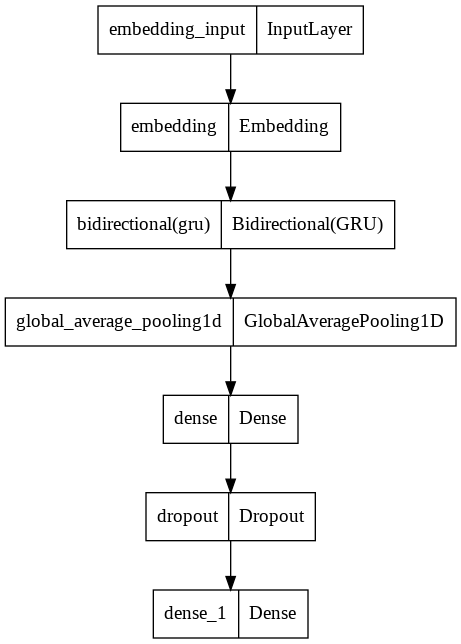

In [42]:
tf.keras.utils.plot_model(model)

In [43]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((32567, 286), (2964, 286), (32567,), (2964,))

In [44]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

### Model training


In [45]:
num_epochs = 10
history = model.fit(x_train, y_train, epochs = num_epochs, validation_data=(x_test, y_test))

Epoch 1/10
1018/1018 [==============================] - 145s 134ms/step - loss: 0.9875 - accuracy: 0.5014 - val_loss: 0.8069 - val_accuracy: 0.6559
Epoch 2/10
1018/1018 [==============================] - 134s 132ms/step - loss: 0.7701 - accuracy: 0.6703 - val_loss: 0.6634 - val_accuracy: 0.7419
Epoch 3/10
1018/1018 [==============================] - 133s 131ms/step - loss: 0.6063 - accuracy: 0.7869 - val_loss: 0.5323 - val_accuracy: 0.7999
Epoch 4/10
1018/1018 [==============================] - 133s 130ms/step - loss: 0.4610 - accuracy: 0.8388 - val_loss: 0.4660 - val_accuracy: 0.8323
Epoch 5/10
1018/1018 [==============================] - 133s 130ms/step - loss: 0.3778 - accuracy: 0.8697 - val_loss: 0.4970 - val_accuracy: 0.8337
Epoch 6/10
1018/1018 [==============================] - 132s 130ms/step - loss: 0.3240 - accuracy: 0.8868 - val_loss: 0.5077 - val_accuracy: 0.8411
Epoch 7/10
1018/1018 [==============================] - 133s 130ms/step - loss: 0.2818 - accuracy: 0.8988 - val_

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

### Model Accuracy and loss

In [47]:
print(f"Accuracy on training data is:- {acc[-1]*100} %")
print(f"Loss {loss[-1]*100}")

print(f"Accuracy on validation data is:- {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]*100}")

Accuracy on training data is:- 91.5681540966034 %
Loss 21.77179902791977
Accuracy on validation data is:- 81.37651681900024 %
Loss 71.67332172393799


### Ploting

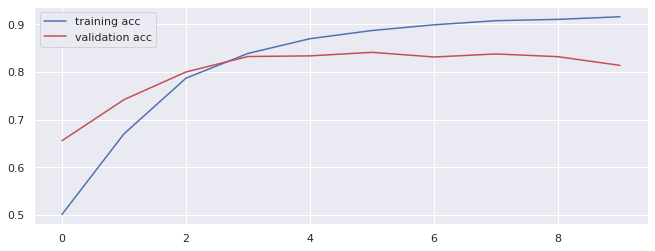

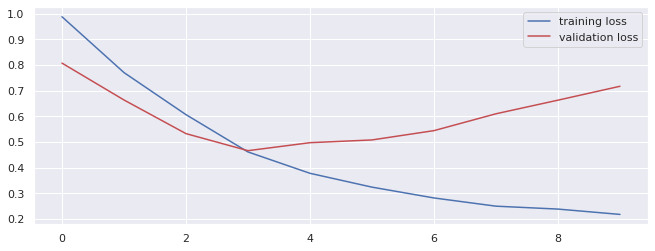

In [48]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'training acc')
plt.plot(epochs, val_acc, 'r', label = 'validation acc')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'b', label="training loss")
plt.plot(epochs, val_loss, 'r', label="validation loss")
plt.legend()
plt.show()

In [49]:
pred = model.predict(x_test)
pred_classes = np.argmax(pred, axis=1)

### Confusion Matrix

In [50]:
cm = confusion_matrix(np.argmax(y_test,1),pred_classes)
cm

array([[ 401,   49,   47],
       [  89, 1004,  114],
       [ 107,  146, 1007]])

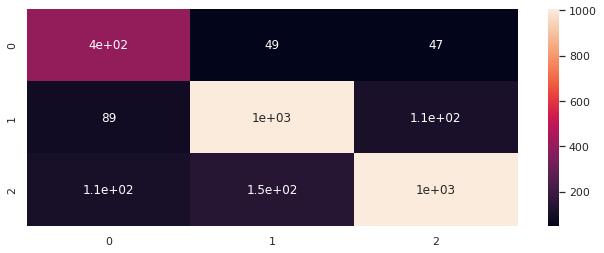

In [51]:
sns.heatmap(cm, annot= True)

### Classification Report

In [52]:
print(classification_report(np.argmax(y_test,1), pred_classes))

              precision    recall  f1-score   support

           0       0.67      0.81      0.73       497
           1       0.84      0.83      0.83      1207
           2       0.86      0.80      0.83      1260

    accuracy                           0.81      2964
   macro avg       0.79      0.81      0.80      2964
weighted avg       0.82      0.81      0.82      2964

